This notebook produces visualizations of the model interpretable parameters (or parameter–derived quantities) in space and time.

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import equinox as eqx
import jax.numpy as jnp
from hydra_zen import instantiate, load_from_yaml
from IPython.display import HTML
from matplotlib import animation
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import lambertw
import xarray as xr

from src.ec_mlp.data_driven_model import DataDrivenModel
from src.ec_mlp.drift_model import DriftModel
from src.ec_mlp.trainer_module import TrainerModule

In [2]:
ROOT = Path(".")
RUNS_DIR = ROOT / "euler_criterion/mlp/multirun/2026-02-08/09-28-33"
RUN_ID = "15"
DATA_DIR = ROOT / "data"

In [3]:
run_cfg = load_from_yaml(RUNS_DIR / RUN_ID / ".hydra/config.yaml")

In [4]:
trunk = instantiate(run_cfg.trunk)()
physical_head = instantiate(run_cfg.physical_head)()
mdn_head = instantiate(run_cfg.mdn_head)()

In [5]:
data_driven_model = DataDrivenModel(trunk, physical_head, mdn_head)
drift_model = DriftModel(
    data_driven_model=data_driven_model, 
    stress_normalization=1.0, 
    wind_normalization=1.0,
    delta_t=1.0 * 60.0 * 60.0  # 1 hour in seconds
)

In [6]:
drift_model = TrainerModule.load_from_checkpoint(
    RUNS_DIR / RUN_ID / "best_model.ckpt", drift_model=drift_model
).drift_model

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:96: The state dict in PosixPath('euler_criterion/mlp/multirun/2026-02-08/09-28-33/15/best_model.ckpt') contains no parameters.


In [7]:
lats = np.arange(-90, 91, 1)
lons = np.arange(-180, 181, 1)
grid_lat, grid_lon = np.meshgrid(lats, lons, indexing="ij")

months = np.arange(1, 13)
month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]
month_abbrv = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

inputs_3d = np.zeros((len(months), len(lats), len(lons), 3))
inputs_3d[..., 0] = np.repeat(months[:, np.newaxis, np.newaxis], len(lats), axis=1).repeat(len(lons), axis=2)
inputs_3d[..., 1] = np.repeat(grid_lat[np.newaxis, ..., :], len(months), axis=0)
inputs_3d[..., 2] = np.repeat(grid_lon[np.newaxis, ..., :], len(months), axis=0)
inputs_1d = inputs_3d.reshape(-1, 3)

physical_parameters, mdn_parameters = eqx.filter_vmap(
    lambda arr: drift_model.get_physical_and_mdn_parameters(
        arr[0], arr[1], arr[2], to_physical_space=True, in_degrees=True
    )
)(jnp.asarray(inputs_1d))

In [8]:
beta_e, theta_e, beta_w = physical_parameters
pi_k, mu_k, sigma_k, rho_k = mdn_parameters

In [9]:
u_eps_mean, v_eps_mean = eqx.filter_vmap(drift_model.get_mean_residual_velocity_from_mdn_parameters)(pi_k, mu_k)

u_eps_mode, v_eps_mode = eqx.filter_vmap(drift_model.get_mode_residual_velocity_from_mdn_parameters)(pi_k, mu_k)

def get_mean_diffusivity(pi_k, mu_k, sigma_k, rho_k):
    K_tensor = drift_model.get_diffusivity_tensor_from_mdn_parameters(pi_k, mu_k, sigma_k, rho_k)
    return jnp.trace(K_tensor) / 2.0

K_mean = eqx.filter_vmap(get_mean_diffusivity)(pi_k, mu_k, sigma_k, rho_k)

In [10]:
uv_eps_mean = (u_eps_mean ** 2 + v_eps_mean ** 2) ** 0.5
uv_eps_mode = (u_eps_mode ** 2 + v_eps_mode ** 2) ** 0.5

In [11]:
beta_e_map = beta_e.reshape(len(months), len(lats), len(lons))
theta_e_map = theta_e.reshape(len(months), len(lats), len(lons))
beta_w_map = beta_w.reshape(len(months), len(lats), len(lons))
uv_eps_mean_map = uv_eps_mean.reshape(len(months), len(lats), len(lons))
uv_eps_mode_map = uv_eps_mode.reshape(len(months), len(lats), len(lons))
K_mean_map = K_mean.reshape(len(months), len(lats), len(lons))

In [12]:
# grid = xr.Dataset(
#     {
#         "month": (["month"], months),
#         "latitude": (["latitude"], lats),
#         "longitude": (["longitude"], lons)
#     }
# )

# xr.open_mfdataset(
#     "../../../data/density/*.nc",
#     drop_variables=[
#         "Density_L2", "Density_L1", "Density_relerr", "climatology_bounds", "obsid", "obsDensity",
#         "obslon", "obslat", "obstime", "obsdepth"
#     ]
# ).interp(
#     depth=0, kwargs={"fill_value": "extrapolate"}
# ).drop_vars(
#     "depth"
# ).rename(
#     {"Density": "density", "lat": "latitude", "lon": "longitude", "time": "month"}
# ).assign_coords(
#     month=months
# ).interp_like(
#     grid
# ).chunk(
#     -1
# ).to_zarr(
#     DATA_DIR / "density_climatology.zarr", mode="w"
# )

In [13]:
density_ds = xr.open_zarr(DATA_DIR / "density_climatology.zarr")
f = 2 * 7.2921e-5 * np.sin(np.radians(density_ds.latitude))  # Coriolis parameter

def invert_ekman_layer_depth(beta_e, f, rho):
    """
    Folowing Ekman theory and the empirical Ekman model definition:
    $$
    \beta_e = \frac{\sqrt{2}}{\rho f D_e} e^{\frac{z}{D_e}}
    $$
    using the Lambert W function, we can solve for the Ekman layer depth $D_e$, 
    given $\beta_e$, the Coriolis parameter $f$, and the reference density $\rho$:
    $$
    D_e = \frac{z}{W \left( \beta_e z \frac{\rho f}{\sqrt{2}} \right)}
    """
    z = -15  # reference depth in meters
    W_arg = beta_e * z * rho * np.abs(f) / np.sqrt(2)
    lw = xr.where(W_arg > -1 / np.e, lambertw(W_arg, k=0), lambertw(W_arg, k=-1))
    D_e = z / np.real(lw)
    return D_e

ekman_layer_depth_map = invert_ekman_layer_depth(np.asarray(beta_e_map), f, density_ds.density)

ekman_layer_depth_map.attrs["long_name"] = "Ekman layer depth implied by $\\beta_e$"
ekman_layer_depth_map.attrs["units"] = "m"

In [14]:
mask_ds = xr.open_zarr(DATA_DIR / "sea_land_mask.zarr")
mask = mask_ds["is_sea"]
mask_int = mask.astype(int)
mask_coarse = mask_int.coarsen(latitude=4, longitude=4, boundary="trim").mean()
mask_1deg = (mask_coarse.interp(latitude=lats, longitude=lons, method="nearest") > 0.5).values

In [15]:
FONTSIZE_TITLE = 16
FONTSIZE_LABEL = 14
FONTSIZE_TICK = 12
FONTSIZE_LEGEND = 12


def save_figure(fig, save_path, dpi=300, transparent=False):
    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=transparent,
            facecolor=fig.get_facecolor() if not transparent else "none",
            edgecolor="none",
        )


def to_da(arr):
    da = xr.DataArray(
        arr,
        coords={
            "month": months,
            "latitude": lats,
            "longitude": lons
        },
        dims=["month", "latitude", "longitude"],
    )
    da = da.where(mask_1deg)
    return da


def plot_field(da, cmap, vmin, vmax, label, fig=None, ax=None, save_path=None, dpi=300):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})

    im = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.025,
            "fraction": 0.05,
            "label": label,
        },
    )

    # Set colorbar font sizes
    cbar = im.colorbar
    cbar.ax.tick_params(labelsize=FONTSIZE_TICK)
    cbar.set_label(label, fontsize=FONTSIZE_LABEL)

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color="lightgrey")

    fig.tight_layout()

    save_figure(fig, save_path, dpi=dpi)

    return fig, ax, im


def plot_annual_movie(da, cmap, vmin, vmax, label, save_path=None, dpi=300, fps=2.5):
    fig, ax, im = plot_field(da.isel(month=0), cmap, vmin, vmax, label)
    title = ax.set_title(month_names[0], fontsize=FONTSIZE_TITLE)

    def update_frame(frame):
        """Update plot for a given frame."""
        im.set_array(da.isel(month=frame).values.ravel())
        title.set_text(month_names[frame])

    def save_frames(save_path, dpi):
        """Save each frame as an individual PNG file."""
        save_path = Path(save_path)
        frames_dir = save_path.parent / save_path.stem
        frames_dir.mkdir(parents=True, exist_ok=True)
        
        n_frames = len(months)
        n_digits = len(str(n_frames - 1))
        
        for frame in range(n_frames):
            update_frame(frame)
            frame_path = frames_dir / f"{str(frame).zfill(n_digits)}.png"
            fig.savefig(
                frame_path,
                dpi=dpi,
                bbox_inches="tight",
                pad_inches=0.1,
                facecolor=fig.get_facecolor(),
                edgecolor="none",
            )
        
        print(f"Saved {n_frames} frames to {frames_dir}")

    if save_path is not None:
        save_frames(save_path, dpi)

    def update(frame):
        update_frame(frame)
        return im, title

    interval = 1000 / fps
    anim = animation.FuncAnimation(fig, update, frames=len(months), interval=interval, blit=True, repeat=True)

    return HTML(anim.to_html5_video())


def plot_annual_mean_field(da, cmap, vmin, vmax, label, title=None, save_path=None, dpi=300):
    fig, ax, _ = plot_field(da.mean(dim="month"), cmap, vmin, vmax, label)
    ax.set_title(title or "Annual mean", fontsize=FONTSIZE_TITLE)

    save_figure(fig, save_path, dpi=dpi)

    return fig, ax


def plot_spatial_mean(da, label, take_abs=False, save_path=None, dpi=300):
    da = da.where(np.isfinite(da))

    da_north = da.sel(latitude=slice(0, 90))
    da_south = da.sel(latitude=slice(-90, 0))

    if take_abs:
        da_north = np.abs(da_north)

    fig, ax = plt.subplots()
    da_north.weighted(np.cos(np.deg2rad(da_north.latitude))).mean(
        dim=["latitude", "longitude"]
    ).plot(ax=ax, label="Northern Hemisphere", linestyle="-", marker="o")

    da_south.weighted(np.cos(np.deg2rad(da_south.latitude))).mean(
        dim=["latitude", "longitude"]
    ).plot(ax=ax, label="Southern Hemisphere", linestyle="--", marker="x")

    ax.legend(fontsize=FONTSIZE_LEGEND)
    ax.set_title("Seasonal variability", fontsize=FONTSIZE_TITLE)
    
    ax.set_xticks(months)
    ax.set_xticklabels(month_abbrv, fontsize=FONTSIZE_TICK)
    ax.set_xlabel("Month", fontsize=FONTSIZE_LABEL)
    ax.set_ylabel(label, fontsize=FONTSIZE_LABEL)
    ax.tick_params(axis="y", labelsize=FONTSIZE_TICK)
    ax.grid(True, alpha=0.3)

    fig.tight_layout()

    save_figure(fig, save_path, dpi=dpi)

    return fig, ax

In [16]:
def extended_center_cmap(base_cmap, vmin, vcenter_low, vcenter_high, vmax, n=256):
    lower = (vcenter_low - vmin) / (vmax - vmin)
    upper = (vcenter_high - vmin) / (vmax - vmin)

    colors_low  = base_cmap(np.linspace(0.0, 0.5, int(n * lower)))
    colors_mid  = np.ones((int(n * (upper - lower)), 4))
    colors_high = base_cmap(np.linspace(0.5, 1.0, n - len(colors_low) - len(colors_mid)))

    colors = np.vstack((colors_low, colors_mid, colors_high))
    return ListedColormap(colors)

### $\beta_e$

In [17]:
da = to_da(beta_e_map)

vmax = da.max()
label = "$\\beta_e$ (m$^2$ s kg$^{-1}$)"

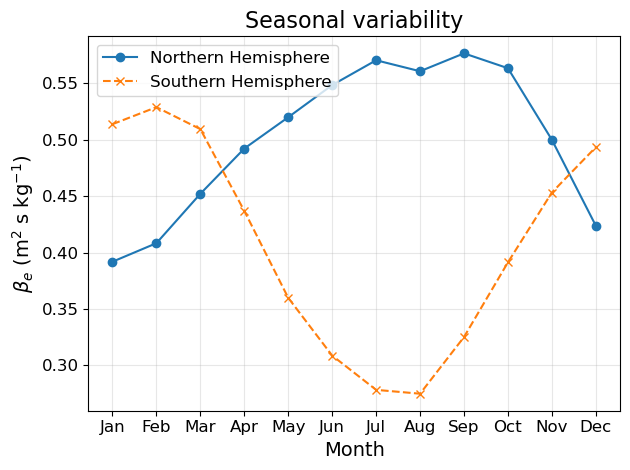

In [ ]:
fig, ax = plot_spatial_mean(da, label, save_path=ROOT / "beta_e_seasonal_cycle.png", dpi=300)
plt.show()

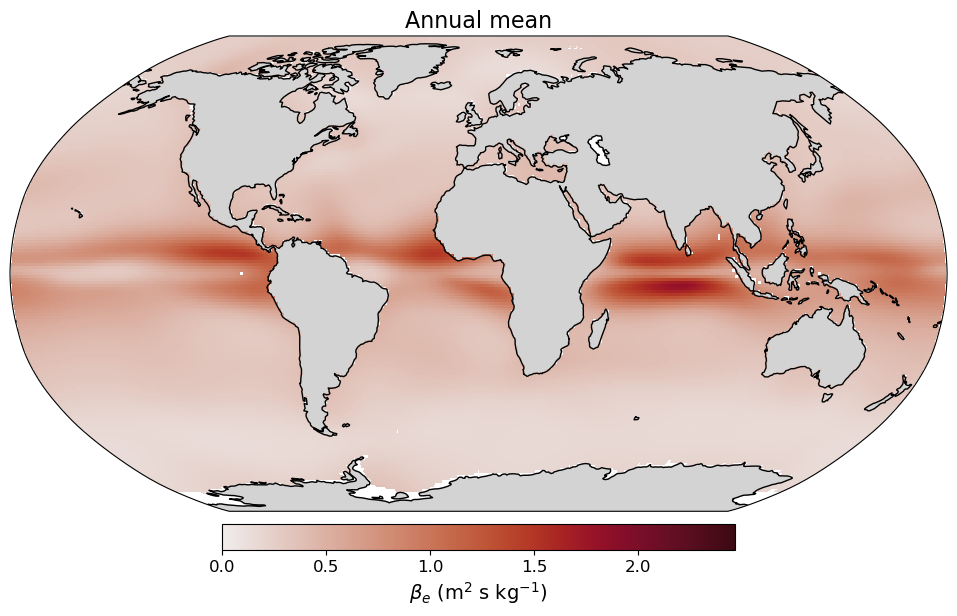

In [19]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [20]:

plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label, save_path=ROOT / "beta_e_annual_cycle.mp4")

Saved 12 frames to beta_e_annual_cycle


### $\theta_e$

In [21]:
da = to_da(theta_e_map)

vmax = np.abs(da).max()
vcenter = 45

theta_e_cmap = extended_center_cmap(
    base_cmap=cmo.balance, vmin=-vmax, vcenter_low=-vcenter, vcenter_high=vcenter, vmax=vmax
)

label = "$\\theta_e$ (°)"

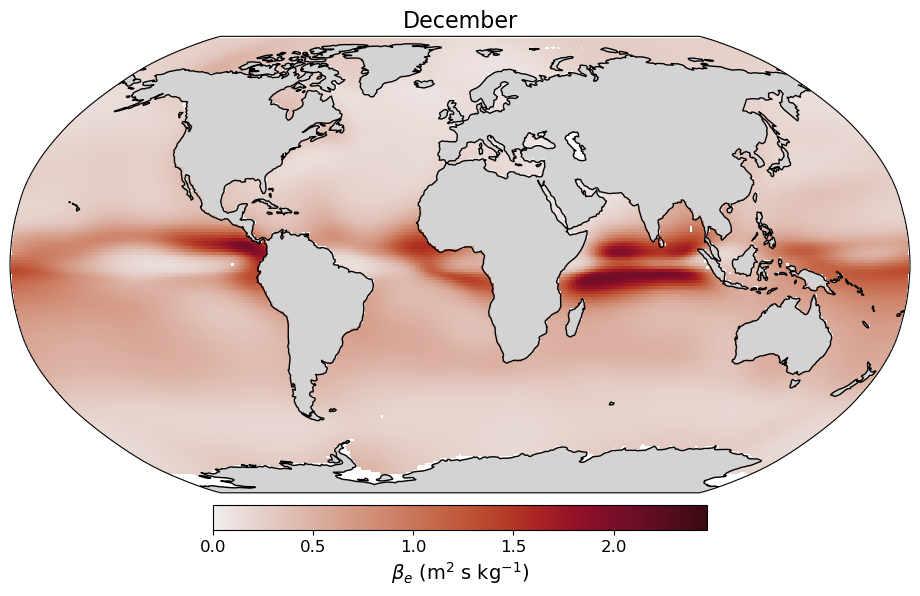

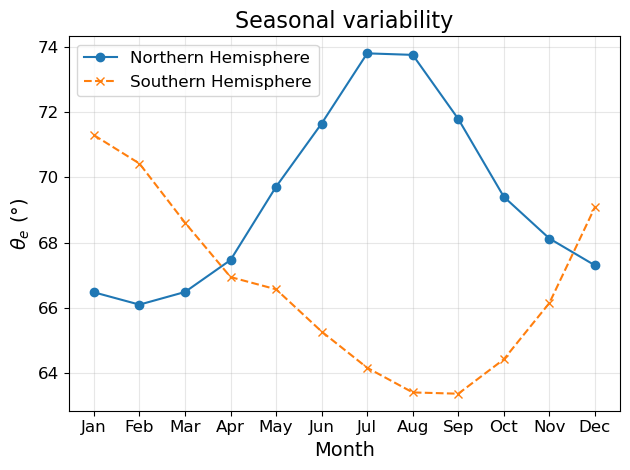

In [ ]:
fig, ax = plot_spatial_mean(da, label, take_abs=True, save_path=ROOT / "theta_e_seasonal_cycle.png", dpi=300)
plt.show()

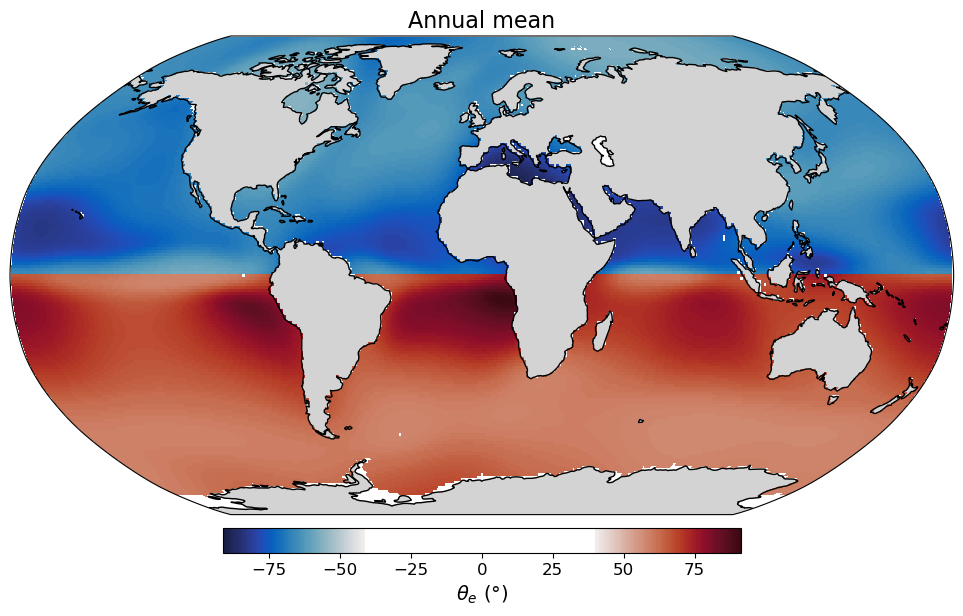

In [23]:
fig, ax = plot_annual_mean_field(da, theta_e_cmap, None, None, label)
plt.show()

In [24]:

plt.ioff()
plot_annual_movie(da, theta_e_cmap, None, None, label, save_path=ROOT / "theta_e_annual_cycle.mp4")

Saved 12 frames to theta_e_annual_cycle


### $D_E$

In [25]:
da = ekman_layer_depth_map

label = "Ekman layer depth implied by $\\beta_e$ (m)"

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


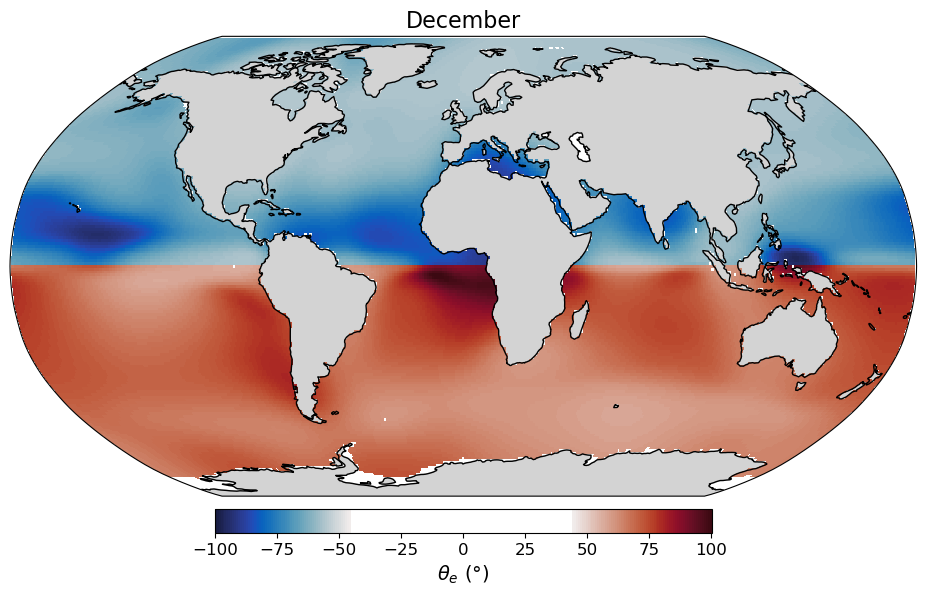

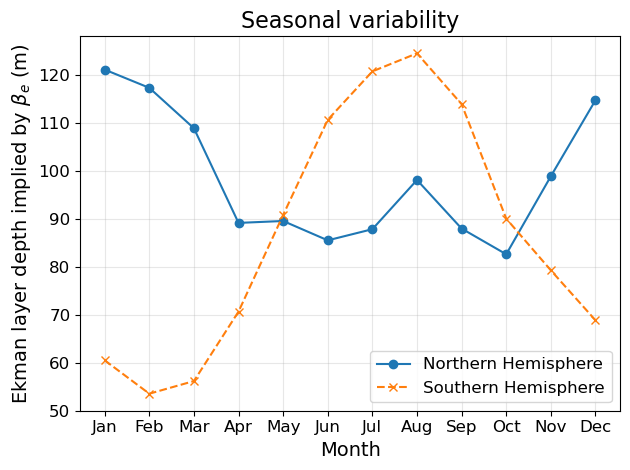

In [26]:
fig, ax = plot_spatial_mean(da, label, take_abs=True)
plt.show()

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


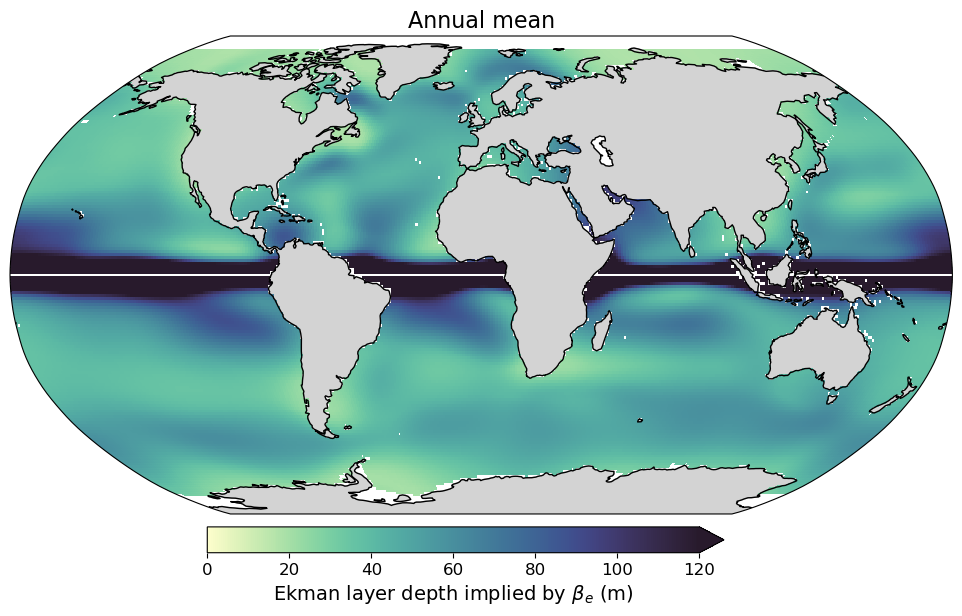

In [27]:
fig, ax = plot_annual_mean_field(da, cmo.deep, 0, 120, label)
plt.show()

In [ ]:

plt.ioff()
plot_annual_movie(da, cmo.deep, 0, 120, label)

### $\beta_w$

In [ ]:
da = to_da(beta_w_map)

vmax = da.max()
label = "$\\beta_w$ (%)"

In [ ]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

In [ ]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [ ]:
plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label, save_path=ROOT / "beta_w_annual_cycle.mp4")

### $\epsilon$

#### mean

In [ ]:
da = to_da(uv_eps_mean_map)

vmax = 0.25
label = "Residual mean (m s$^{-1}$)"

In [ ]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

In [ ]:
fig, ax = plot_annual_mean_field(da, cmo.diff, -vmax, vmax, label)
plt.show()

In [ ]:

plt.ioff()
plot_annual_movie(da, cmo.diff, -vmax, vmax, label, save_path=ROOT / "residual_mean_annual_cycle.mp4")

#### mode

In [ ]:
da = to_da(uv_eps_mode_map)

vmax = 0.25
label = "Residual mode (m s$^{-1}$)"

In [ ]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

In [ ]:
fig, ax = plot_annual_mean_field(da, cmo.diff, -vmax, vmax, label)
plt.show()

In [ ]:

plt.ioff()
plot_annual_movie(da, cmo.diff, -vmax, vmax, label, save_path=ROOT / "residual_mode_annual_cycle.mp4")

### $\mathbf{K}$

In [ ]:
da = to_da(K_mean_map)

vmax = da.max()
label = "Residual diffusivity (m$^2$ s$^{-1}$)"

In [ ]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

In [ ]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [ ]:
plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label, save_path=ROOT / "K_annual_cycle.mp4")